# Temperature change exposure using ERA weather and climatology, 2000-2015

- Project temperature changes between ERA interim and ERA climatology onto gridded population from NASA for 2000-2015
- Calculate global average as sum of exposure divided by total population

### Metric 1.1: Exposure to temperature change

The vulnerability to climate change is a function of the physical hazard (change in temperature, precipitation, humidity etc) and the number of (vulnerable) people exposed. A first order measure of exposure is defined here as:


$$
E(x,t) = \Delta T(x,t)P(x,t)
$$

and the global average is

$$
\bar{E} = \frac{\int \Delta T(x,t)P(x,t) dx}{\int P(x,t) dx}
$$

Where $\Delta T(x,t)$ is the change in the summer mean temperature (Northern Hemisphere JJA, Southern Hemisphere DJF) at location x at time t from the recent historical summer mean (1986-2005). $P(x,t)$ is the population at location x at time t in millions.

**NOTE: The aim of this final indicator is to have an axis in Kelvin, and this is probably the most important one. The reason for this is that it makes it easy to have plots of the raw temperature change and the exposure change side by side and demonstrate with comparable axes that there is an important difference between the change in temperature and the change in temperature experienced by people**


### Updates/Clarifications to Method

Aim is to measure 'temperature change experienced by people'. End goal is a value in Kelvin which is the equivalent of the global mean temperature change but weighted by population

We operate on gridded data.

First, just multiply the temperature change by the number of people at each point (x) for a given time (t):

$$
E(x,t) = \Delta T(x,t)P(x)
$$


We want to limit to the temperature change in the summer months for a given year, so first define all operations for a chosen year Y. The flobal $\Delta T(x,t)$ array is calculated by taking the mean temperature change for June, July, August for the northern hemisphere (latitude >= 0) and joining it with the array ofthe mean temperature change for December, January, February for the southern hemisphere (latitude < 0).

This gives a value in Kelvin x Npeople, which isn't hugely intuitive. When we take the global average with therefore divide by the total population for that year, $\sum P(x)$:

$$
\bar{E} = \frac{\sum \Delta T(x,t)P(x,t)}{\sum P(x)}
$$

This can be repeated for each year to get a time series. However, we'd also like to map the value for each year in a similarly intuitive way. We can do this using the mean population per grid point:

$$
\bar{P} = \sum P(x) / N
$$

And calculating the exposure at each point as the population divided by the mean population:

$$
E(x,t) = \Delta T(x,t)P(x) / \bar{P}
$$

The average of this value over the grid (with number of points N) is equal to the $\bar{E}$:


$$
Mean = \frac{\sum \Delta T(x,t)P(x,t) / \bar{P} }{N} \\
= \frac{\sum \Delta T(x,t)P(x,t) / (\sum P(x) / N) }{N} \\
= \frac{ \tfrac{N}{\sum P(x)} \sum \Delta T(x,t)P(x,t) }{N} \\
= \frac{ N   \sum \Delta T(x,t)P(x,t) }{N \sum P(x)} \\
= \frac{\sum \Delta T(x,t)P(x,t)}{\sum P(x)} = \bar{E} 
$$


#### Notes

Summer:

Northern Hemisphere JJA: June, July, August

Southern Hemisphere DJF: December, January, February



In [1]:
%matplotlib inline

In [4]:
from pathlib import Path
from datetime import date

import rasterio
import numpy as np
import scipy as sp
import pandas as pd
import xarray as xr
import matplotlib.pyplot as plt
import cartopy.crs as ccrs

from scipy import stats
from tqdm import tnrange, tqdm_notebook

import weather_ecmwf
# import population_tools

from config import (DATA_SRC, WEATHER_SRC, POP_DATA_SRC)

In [5]:
plt.rcParams['figure.dpi'] = 100
plt.rcParams['savefig.dpi'] = 300

In [6]:
MAX_YEAR = 2018
REFERENCE_YEAR_START = 1986
REFERENCE_YEAR_END = 2005

ERA_MONTHLY_FILE = WEATHER_SRC / 'era_interim_0.5deg' / 'monthly_means'
CLIMATOLOGY_FILE_MONTHLY = WEATHER_SRC / 'era_interim_0.5deg' / 'era_climatology_monthly.nc'
POPULATION_FILE = POP_DATA_SRC / 'population_count_2000-2020_30min_era_compat.nc'

INTERMEDIATE_RESULTS_FOLDER = DATA_SRC / 'lancet'/ 'summer_temperature'/ 'results_2019'
INTERMEDIATE_RESULTS_FOLDER.mkdir(parents=True, exist_ok=True)

RESULTS_FOLDER = Path('./results/lancet2019/1.1 temperature change')
# RESULTS_FOLDER.mkdir(parents=True, exist_ok=True)

# Load weather

In [8]:
era_weather = weather_ecmwf.weather_mfdataset(ERA_MONTHLY_FILE, combine='by_coords')
era_weather = era_weather.sel(time=slice('1980',f'{MAX_YEAR}'))

In [9]:
era_climatology = weather_ecmwf.climatology_dataset(CLIMATOLOGY_FILE_MONTHLY)

In [10]:
# import ipywidgets
# from ipywidgets import interact

# def _plt_month(month=1):
#     (era_climatology.sel(month=month).temperature_2m - 273.15).plot(vmin=-50, vmax=50, cmap='RdBu_r')

# interact(_plt_month, month=ipywidgets.IntSlider(min=1,max=12,step=1,value=1));


## Get ∆T for each month of each year relative to the ERA climatology monthly means file


In [11]:
def sub_months(era_t_yr):
    #Swap in the time axis so the datasets auto-align
    tmp = era_climatology.temperature_2m.copy().rename({'month':'time'})
    tmp['time'] = era_t_yr.time
    return era_t_yr - tmp
    
delta_t = era_weather.temperature_2m.groupby('time.year').apply(sub_months)

In [12]:
# def _plt_month(month=1, year=2000):
#     (delta_t.sel(time=date(year, month, 1))).plot(vmin=-5, vmax=5, cmap='RdBu_r')

# interact(_plt_month, 
#          month=ipywidgets.IntSlider(min=1,max=12,step=1,value=1),
#          year=ipywidgets.IntSlider(min=1990,max=2018,step=1,value=2000)
#         );


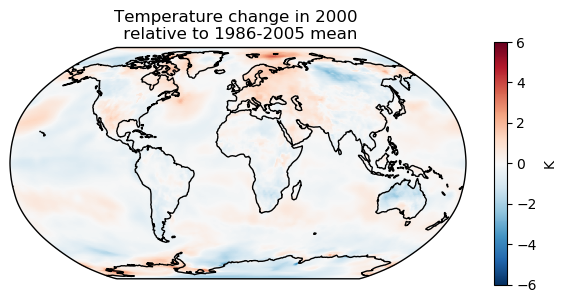

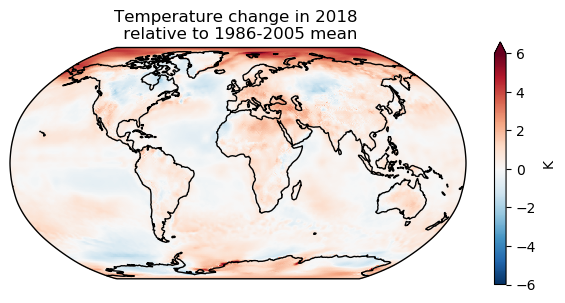

In [13]:
# Climate change in 2000
f = plt.figure(figsize=(6,3))

ax = plt.axes(projection=ccrs.Robinson())
delta_t.sel(time='2000').mean(dim='time').plot.pcolormesh(
    ax=ax,
    transform=ccrs.PlateCarree(),
    cbar_kwargs=dict(label='K'),
    cmap='RdBu_r',
    vmin=-6, vmax=6
)
ax.coastlines()
ax.set_title('Temperature change in 2000 \n relative to 1986-2005 mean')
plt.tight_layout()

f.show()

f = plt.figure(figsize=(6,3))

ax = plt.axes(projection=ccrs.Robinson())
delta_t.sel(time=f'{MAX_YEAR}').mean(dim='time').plot.pcolormesh(
    ax=ax,
    transform=ccrs.PlateCarree(),
    cbar_kwargs=dict(label='K'),
    cmap='RdBu_r',
    vmin=-6, vmax=6
)
ax.coastlines()
ax.set_title(f'Temperature change in {MAX_YEAR} \n relative to 1986-2005 mean')
plt.tight_layout()


f.show()

## Get the mean delta for each summer

In [14]:
def collect_summer_delta(delta_t):
    """Split the word data into north and south, 
    keep only the summer months for each, then re-join them
    """
    # Wrap in a function to clear temporary vars from memory
    
    lat_north = delta_t.latitude[delta_t.latitude >= 0]    
    lat_south = delta_t.latitude[delta_t.latitude < 0]

    # Summer North
    summer_jja = delta_t['time.season'] == 'JJA'

    # Summer South
    summer_djf = delta_t['time.season'] == 'DJF'

    nh = delta_t.sel(time=summer_jja, latitude=lat_north).groupby('time.year').mean(dim='time')
    sh = delta_t.sel(time=summer_djf,latitude=lat_south).groupby('time.year').mean(dim='time')
    
    return xr.concat([nh, sh], dim='latitude')

summer_anom = collect_summer_delta(delta_t)

In [12]:
# def _plt_delta(year=2000):
#     summer_anom.sel(year=year).plot(vmin=-5, vmax=5, cmap='RdBu_r')

# interact(_plt_delta, 
#          month=ipywidgets.IntSlider(min=1,max=12,step=1,value=1),
#          year=ipywidgets.IntSlider(min=1990,max=2018,step=1,value=2000)
#         );


### Save the summer anomaly for use in the country calculation

In [14]:
# summer_anom.name = 'summer_global'
summer_anom.to_netcdf(INTERMEDIATE_RESULTS_FOLDER /'summer_temperature_anomaly.nc')

### Weight the gridded mean anomaly by the latitude and calculate the global mean

- It's important to weight the grid before calculating the mean to account for the change in area of grid units from the equator to the poles

In [15]:
cos_lat = xr.ufuncs.cos(xr.ufuncs.radians(summer_anom.latitude))
summer_anom_ts = (summer_anom.sel(year=slice('2000', None)) * cos_lat).mean(dim=['latitude', 'longitude'])

# Project summer anomaly to total population

In [16]:
population = xr.open_dataarray(POPULATION_FILE)

### Export some example grids

In [26]:
mask = xr.open_dataarray(DATA_SRC/ 'lancet/population/country_codes_30min_era_compat.nc')
mask = (mask > 0) & (mask < 999)

In [41]:
summer_anom.sel(year=2018, drop=True).to_dataset(name='summer_warming').to_netcdf('summer_warming_2018.nc')

In [78]:
summer_anom.sel(year=2018, drop=True).where(mask).to_dataset(name='summer_warming').to_netcdf('summer_warming_masked_2018.nc')

In [47]:
# (summer_anom * mask).sel(year=slice(2008, MAX_YEAR)).mean(dim='year').plot()

# .to_dataset(name='summer_warming').to_netcdf('summer_warming_masked_2018.nc')

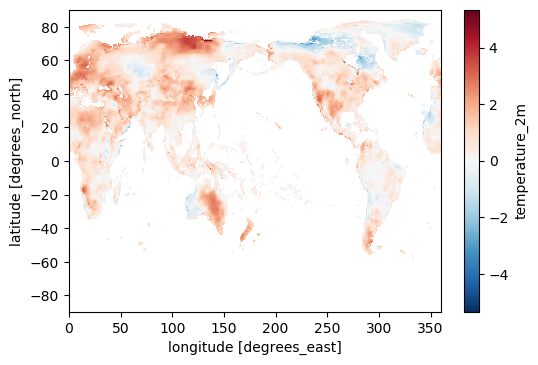

In [56]:
data = summer_anom.sel(year=2018, drop=True).where(mask)
data.plot()

In [97]:
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import matplotlib.pyplot as plt
from matplotlib.patches import PathPatch
import matplotlib.path
import matplotlib.ticker
from matplotlib.transforms import BboxTransform, Bbox
import numpy as np


# When drawing the flag, we can either use white filled land, or be a little
# more fancy and use the Natural Earth shaded relief imagery.
filled_land = True


def olive_path():
    """
    Return a Matplotlib path representing a single olive branch from the
    UN Flag. The path coordinates were extracted from the SVG at
    https://commons.wikimedia.org/wiki/File:Flag_of_the_United_Nations.svg.

    """
    olives_verts = np.array(
        [[0,   2,   6,   9,  30,  55,  79,  94, 104, 117, 134, 157, 177,
          188, 199, 207, 191, 167, 149, 129, 109,  87,  53,  22,   0, 663,
          245, 223, 187, 158, 154, 150, 146, 149, 154, 158, 181, 184, 197,
          181, 167, 153, 142, 129, 116, 119, 123, 127, 151, 178, 203, 220,
          237, 245, 663, 280, 267, 232, 209, 205, 201, 196, 196, 201, 207,
          211, 224, 219, 230, 220, 212, 207, 198, 195, 176, 197, 220, 239,
          259, 277, 280, 663, 295, 293, 264, 250, 247, 244, 240, 240, 243,
          244, 249, 251, 250, 248, 242, 245, 233, 236, 230, 228, 224, 222,
          234, 249, 262, 275, 285, 291, 295, 296, 295, 663, 294, 293, 292,
          289, 294, 277, 271, 269, 268, 265, 264, 264, 264, 272, 260, 248,
          245, 243, 242, 240, 243, 245, 247, 252, 256, 259, 258, 257, 258,
          267, 285, 290, 294, 297, 294, 663, 285, 285, 277, 266, 265, 265,
          265, 277, 266, 268, 269, 269, 269, 268, 268, 267, 267, 264, 248,
          235, 232, 229, 228, 229, 232, 236, 246, 266, 269, 271, 285, 285,
          663, 252, 245, 238, 230, 246, 245, 250, 252, 255, 256, 256, 253,
          249, 242, 231, 214, 208, 208, 227, 244, 252, 258, 262, 262, 261,
          262, 264, 265, 252, 663, 185, 197, 206, 215, 223, 233, 242, 237,
          237, 230, 220, 202, 185, 663],
         [8,   5,   3,   0,  22,  46,  46,  46,  35,  27,  16,  10,  18,
          22,  28,  38,  27,  26,  33,  41,  52,  52,  52,  30,   8, 595,
          77,  52,  61,  54,  53,  52,  53,  55,  55,  57,  65,  90, 106,
          96,  81,  68,  58,  54,  51,  50,  51,  50,  44,  34,  43,  48,
          61,  77, 595, 135, 104, 102,  83,  79,  76,  74,  74,  79,  84,
          90, 109, 135, 156, 145, 133, 121, 100,  77,  62,  69,  67,  80,
          92, 113, 135, 595, 198, 171, 156, 134, 129, 124, 120, 123, 126,
          129, 138, 149, 161, 175, 188, 202, 177, 144, 116, 110, 105,  99,
          108, 116, 126, 136, 147, 162, 173, 186, 198, 595, 249, 255, 261,
          267, 241, 222, 200, 192, 183, 175, 175, 175, 175, 199, 221, 240,
          245, 250, 256, 245, 233, 222, 207, 194, 180, 172, 162, 153, 154,
          171, 184, 202, 216, 233, 249, 595, 276, 296, 312, 327, 327, 327,
          327, 308, 284, 262, 240, 240, 239, 239, 242, 244, 247, 265, 277,
          290, 293, 296, 300, 291, 282, 274, 253, 236, 213, 235, 252, 276,
          595, 342, 349, 355, 357, 346, 326, 309, 303, 297, 291, 290, 297,
          304, 310, 321, 327, 343, 321, 305, 292, 286, 278, 270, 276, 281,
          287, 306, 328, 342, 595, 379, 369, 355, 343, 333, 326, 318, 328,
          340, 349, 366, 373, 379, 595]]).T
    olives_codes = np.array([1, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4,
                             4, 4, 4, 4, 4, 4, 4, 4, 4, 79, 1, 4, 4, 4, 4, 4,
                             4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4,
                             4, 4, 4, 4, 4, 4, 79, 1, 4, 4, 4, 4, 4, 4, 2, 4,
                             4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4,
                             4, 79, 1, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4,
                             4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4,
                             4, 79, 1, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4,
                             4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 2, 4,
                             4, 4, 4, 4, 4, 79, 1, 4, 4, 4, 4, 4, 4, 4, 4, 4,
                             2, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4,
                             4, 4, 4, 4, 4, 4, 79, 1, 4, 4, 4, 4, 4, 4, 4, 4,
                             4, 2, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4,
                             4, 4, 4, 4, 79, 1, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4,
                             4, 4, 79], dtype=np.uint8)

    return matplotlib.path.Path(olives_verts, olives_codes)


def main():
    blue = '#4b92db'

    # We're drawing a flag with a 3:5 aspect ratio.
    fig = plt.figure(figsize=[7, 4.5], facecolor=blue)
    # Put a blue background on the figure.
    blue_background = PathPatch(matplotlib.path.Path.unit_rectangle(),
                                transform=fig.transFigure, color=blue,
                                zorder=-1)
    fig.patches.append(blue_background)

    # Set up the Azimuthal Equidistant and Plate Carree projections
    # for later use.
    az_eq = ccrs.AzimuthalEquidistant(central_latitude=90)
    pc = ccrs.PlateCarree()

    # Pick a suitable location for the map (which is in an Azimuthal
    # Equidistant projection).
    ax = fig.add_axes([0.25, 0.24, 0.5, 0.54], projection=az_eq)

    # The background patch and outline patch are not needed in this example.
    ax.background_patch.set_facecolor('none')
    ax.outline_patch.set_edgecolor('none')

    # We want the map to go down to -60 degrees latitude.
    ax.set_extent([-180, 180, -60, 90], ccrs.PlateCarree())

    # Importantly, we want the axes to be circular at the -60 latitude
    # rather than cartopy's default behaviour of zooming in and becoming
    # square.
    _, patch_radius = az_eq.transform_point(0, -60, pc)
    circular_path = matplotlib.path.Path.circle(0, patch_radius)
    ax.set_boundary(circular_path)
#     ax.add_feature(
#             cfeature.LAND, facecolor='white', edgecolor='none')


    gl = ax.gridlines(crs=pc, linewidth=1, color='white', linestyle='-')
    # Meridians every 45 degrees, and 5 parallels.
    gl.xlocator = matplotlib.ticker.FixedLocator(np.arange(0, 361, 45))
    parallels = np.linspace(-60, 70, 5, endpoint=True)
    gl.ylocator = matplotlib.ticker.FixedLocator(parallels)

    data = summer_anom.sel(year=2018, drop=True).where(mask)
    data.plot.pcolormesh(ax=ax,
                          transform=ccrs.PlateCarree(),
                         cmap='RdBu_r',
                         add_colorbar=False,
                         vmin=-3, vmax=3
                               )
    ax.coastlines(color='lightgrey', linewidth=0.5)
    
    # Now add the olive branches around the axes. We do this in normalised
    # figure coordinates
    olive_leaf = olive_path()

    olives_bbox = Bbox.null()
    olives_bbox.update_from_path(olive_leaf)

    # The first olive branch goes from left to right.
    olive1_axes_bbox = Bbox([[0.47, 0.15], [0.725, 0.75]])
    olive1_trans = BboxTransform(olives_bbox, olive1_axes_bbox)

    # THe second olive branch goes from right to left (mirroring the first).
    olive2_axes_bbox = Bbox([[0.53, 0.15], [0.275, 0.75]])
    olive2_trans = BboxTransform(olives_bbox, olive2_axes_bbox)

    olive1 = PathPatch(olive_leaf, facecolor='white', edgecolor='none',
                       transform=olive1_trans + fig.transFigure)
    olive2 = PathPatch(olive_leaf, facecolor='white', edgecolor='none',
                       transform=olive2_trans + fig.transFigure)

    fig.patches.append(olive1)
    fig.patches.append(olive2)

    return fig

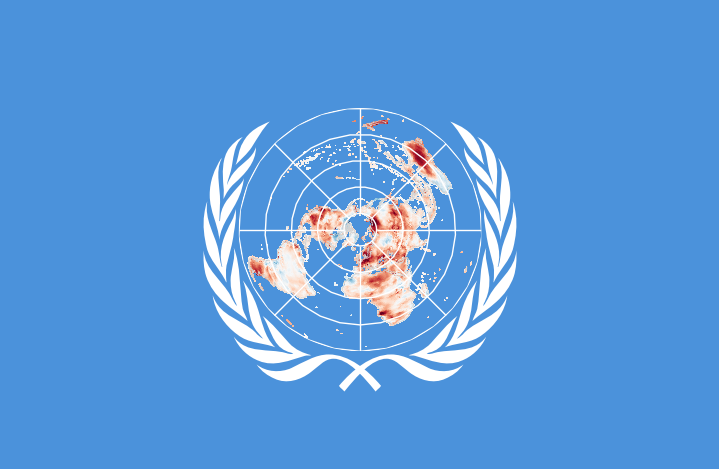

In [98]:
f = main()
f.savefig('UN Warming.png')

## Calculate the exposure

In [17]:
summer_exposures_ts = (summer_anom * population / population.sum(dim=['latitude', 'longitude'], skipna=True)).sum(dim=['latitude', 'longitude'], skipna=True)

In [18]:
summer_exposures_ts = summer_exposures_ts.compute()

## Save/load the exposure time series

In [16]:
summer_exposures_ts.name = 'summer_exposure'
summer_exposures_ts.to_dataframe().to_excel(RESULTS_FOLDER / 'summer_exposure_ts.xlsx')


In [4]:
summer_exposures_ts = pd.read_excel(RESULTS_FOLDER / 'summer_exposure_ts.xlsx', index_col='year')
summer_exposures_ts = summer_exposures_ts.to_xarray().summer_exposure


## Plot the time series

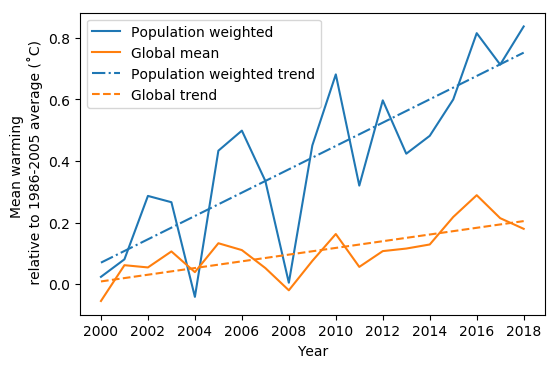

In [21]:
summer_exposures_ts.plot(color='C0',label='Population weighted')
summer_anom_ts.plot(color='C1',label='Global mean')
# mean_exposures_ts.plot(color='C9', label='Experienced, Year 2000 baseline')

summer_anom_params = stats.linregress(summer_anom_ts.year.values, summer_anom_ts.values)
summer_anom_reg = (summer_anom_params.slope * summer_anom_ts.year) + summer_anom_params.intercept

summer_exposures_params = stats.linregress(summer_exposures_ts.year.values, summer_exposures_ts.values)
summer_exposures_reg = (summer_exposures_params.slope * summer_exposures_ts.year) + summer_exposures_params.intercept

summer_exposures_reg.plot.line('-.', color='C0', label='Population weighted trend')
summer_anom_reg.plot.line('--', color='C1', label='Global trend')

plt.xticks(list(range(2000, MAX_YEAR + 1, 2)))
plt.xlabel('Year')
plt.ylabel('Mean warming \n relative to 1986-2005 average (˚C)')
plt.legend()
plt.savefig(RESULTS_FOLDER / f'mean_warming_experienced_2000-{MAX_YEAR}.png', dpi=300)
# plt.savefig(RESULTS_FOLDER / f'mean_warming_experienced_2000-{MAX_YEAR}.pdf')


In [17]:
summer_exposures_params

LinregressResult(slope=0.0378636831119923, intercept=-75.65761073686824, rvalue=0.8016386173877518, pvalue=3.6808123837861444e-05, stderr=0.00684829043207561)

In [18]:
summer_anom_params

LinregressResult(slope=0.01087851010834714, intercept=-21.748240061849728, rvalue=0.73544415139396, pvalue=0.00033297354305845815, stderr=0.0024308561803662435)

In [28]:
# Save to excel
output = summer_anom_ts.to_dataframe(name='Global mean change K').join(summer_exposures_ts.to_dataframe(name='Exposure weighted change K'))

output.to_excel(RESULTS_FOLDER / 'temperature_change.xlsx', sheet_name='temperature_change')

## Map plots

- Plot the mean change/year over the period of interest


# Checking that the 2019 work gives the same result as the 2018 one


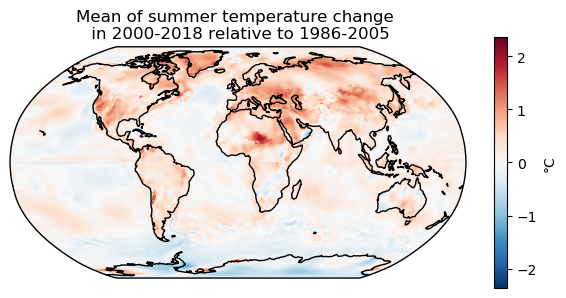

In [12]:
year_anom_delta = summer_anom.sel(year=slice(2000, MAX_YEAR)).mean(dim='year')

f,ax = plt.subplots(figsize=(6,3), 
               subplot_kw=dict(projection=ccrs.Robinson()))

year_anom_delta.plot.pcolormesh(ax=ax,
                          transform=ccrs.PlateCarree(),
                          cbar_kwargs=dict(label='°C'),
                                cmap='RdBu_r',
#                                 vmin=-3, vmax=3
                               
                               )
ax.coastlines()
ax.set_title(f'Mean of summer temperature change \n in 2000-{MAX_YEAR} relative to 1986-2005')
plt.tight_layout()
f.savefig(RESULTS_FOLDER / f'temperature_change_delta_map_2000-{MAX_YEAR}_robinson.png', dpi=600)

In [19]:
# output = pd.read_excel(Path('./results/lancet2018/global/1.1 temperature change') / 'temperature_change.xlsx',
#                        sheet_name='temperature_change', index_col='year')

# output['Exposure weighted change K'].plot()
# summer_exposures_ts.plot()

In [19]:
# no longer needed when we have the pre-processed population data at the correct resolution.
# summer_exposures_ts = population_tools.project_to_population(summer_anom, norm=True, end_year=MAX_YEAR)

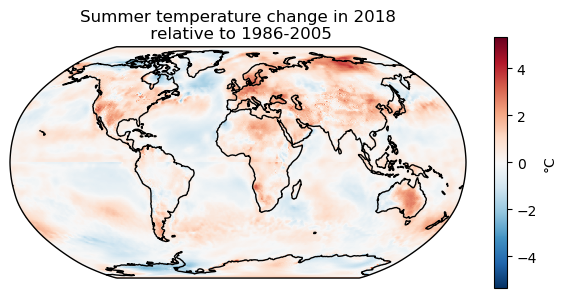

In [13]:
year_anom_delta = summer_anom.sel(year= MAX_YEAR, drop=True)

f,ax = plt.subplots(figsize=(6,3), 
               subplot_kw=dict(projection=ccrs.Robinson()))

year_anom_delta.plot.pcolormesh(ax=ax,
                          transform=ccrs.PlateCarree(),
                          cbar_kwargs=dict(label='°C'),
                                cmap='RdBu_r',
#                                 vmin=-3, vmax=3
                               
                               )
ax.coastlines()
ax.set_title(f'Summer temperature change in {MAX_YEAR}\n relative to 1986-2005')
plt.tight_layout()
f.savefig(RESULTS_FOLDER / f'temperature_change_delta_map_{MAX_YEAR}.png', dpi=600)